In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch.nn.functional as F

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and processor
model_name = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(model_name, attn_implementation="eager").to(device)
model.eval()
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Using device: cpu


In [2]:
import kagglehub
import os
import json

In [3]:
# Download dataset
data_path = kagglehub.dataset_download(
    "nagasai524/mini-coco2014-dataset-for-image-captioning")

In [4]:
def load_captions(dataset_path):
    """Load image_id -> list of captions mapping from captions.json."""
    captions_path = os.path.join(dataset_path, "captions.json")
    with open(captions_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"] if isinstance(data, dict) else data

    captions = {}
    for ann in annotations:
        img_id = ann["image_id"]
        captions.setdefault(img_id, []).append(ann["caption"])
    return captions

In [5]:
def find_image_folder(dataset_path, ext=".jpg"):
    """Find first folder under dataset_path that contains image files."""
    for root, _, files in os.walk(dataset_path):
        if any(f.lower().endswith(ext) for f in files):
            return root
    raise RuntimeError(f"No image folder with *{ext} found under {dataset_path}")

In [6]:
captions = load_captions(data_path)
img_folder = find_image_folder(data_path)
img_ids = sorted(captions.keys())

print(f"Dataset loaded, {len(img_ids)} images with captions")

Dataset loaded, 18783 images with captions


In [7]:
def get_image(idx):
    """Load image and its captions by index in img_ids."""
    img_id = img_ids[idx]

    # Try common filename patterns
    candidates = [
        os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg"),
        os.path.join(img_folder, f"{img_id}.jpg"),
    ]

    for img_path in candidates:
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            return img, captions[img_id]

    raise FileNotFoundError(f"No image file found for image_id {img_id}")


In [8]:
def generate_caption_from_pixel_values(pixel_values):
    generated_ids = model.generate(pixel_values, max_length=16, num_beams=1)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

def perform_aaa_attack(img, epsilon=2.0):
    model.train()  # Allow gradient tracking

    # Prepare input image
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    pixel_values.requires_grad = True

    # Get target caption (could also use GT, here we use the base model output)
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=16, num_beams=1)
    base_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    # Get token IDs for caption
    base_ids = tokenizer(base_caption, return_tensors="pt", add_special_tokens=True).input_ids.to(device)

    # Forward pass with gradients
    outputs = model(pixel_values=pixel_values, labels=base_ids)
    loss = outputs.loss
    loss.backward()

    # FGSM: Add perturbation in direction of gradient sign
    grad = pixel_values.grad.data
    perturbed = pixel_values + epsilon * grad.sign()
    perturbed = torch.clamp(perturbed, 0, 1)  # Clip to valid image range

    # Generate adversarial caption
    adv_ids = model.generate(perturbed, max_length=16, num_beams=1)
    adv_caption = tokenizer.decode(adv_ids[0], skip_special_tokens=True)

    return pixel_values[0], perturbed[0], base_caption, adv_caption


In [9]:
def tensor_to_pil(tensor_img):
    # (C, H, W) → (H, W, C)
    img = tensor_img.detach().cpu().permute(1, 2, 0).numpy()

    # undo normalization from ViTImageProcessor
    mean = np.array(feature_extractor.image_mean)
    std = np.array(feature_extractor.image_std)

    img = img * std + mean     # unnormalize
    img = np.clip(img, 0, 1)   # ensure valid range
    img = (img * 255).astype(np.uint8)

    return Image.fromarray(img)

def show_attack(original_tensor, adv_tensor, base_caption, adv_caption):
    orig_img = tensor_to_pil(original_tensor)
    adv_img = tensor_to_pil(adv_tensor)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title(f"Original\n'{base_caption}'", fontsize=10)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(adv_img)
    plt.title(f"Adversarial\n'{adv_caption}'", fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


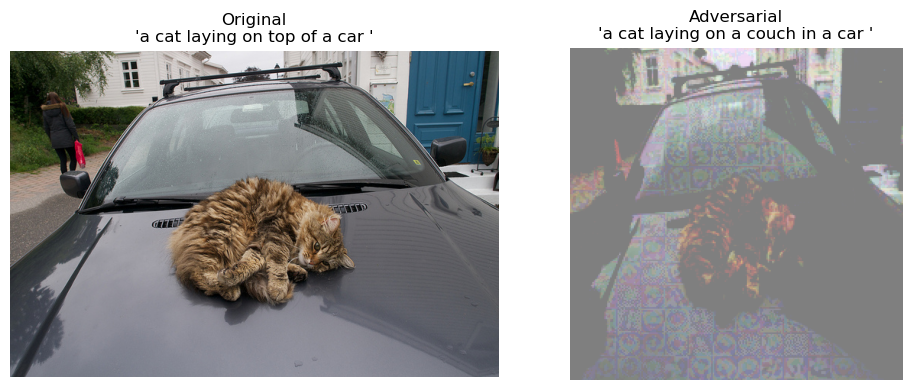

In [14]:
idx = 6000
orig_img, _ = get_image(idx)
orig_tensor, adv_tensor, cap_orig, cap_adv = perform_aaa_attack(orig_img, epsilon=0.08)
orig_vis = tensor_to_pil(orig_tensor)
adv_vis = tensor_to_pil(adv_tensor)

# Show side by side
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(f"Original\n'{cap_orig}'")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adv_vis)
plt.title(f"Adversarial\n'{cap_adv}'")
plt.axis("off")
plt.tight_layout()
plt.show()
